In [1]:
%pylab inline
import pickle
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

Populating the interactive namespace from numpy and matplotlib


Load the MNIST dataset.

In [2]:
mnist = fetch_mldata('MNIST original', data_home=".")

In [3]:
mnist["data"].shape

(70000, 784)

Take random 2500 images - we will project them to 50 x 50 grid.

In [4]:
size = 50
N = size * size
data, target = shuffle(mnist["data"], mnist["target"], random_state=777, n_samples=N)

PCA them to 100 dimensions and run t-SNE. Normalize the results to [0, 1].

In [19]:
data_100 = PCA(n_components=100).fit_transform(data.astype(float32) / 255)
embeddings = TSNE(init="pca", random_state=777, verbose=2).fit_transform(data_100)
embeddings -= embeddings.min(axis=0)
embeddings /= embeddings.max(axis=0)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 2.334216
[t-SNE] Iteration 25: error = 1.6845140, gradient norm = 0.0033264
[t-SNE] Iteration 50: error = 1.6225266, gradient norm = 0.0031101
[t-SNE] Iteration 75: error = 1.3815724, gradient norm = 0.0016624
[t-SNE] Iteration 100: error = 1.3267819, gradient norm = 0.0015992
[t-SNE] Error after 100 iterations with early exaggeration: 1.326782
[t-SNE] Iteration 125: error = 1.2389326, gradient norm = 0.0010897
[t-SNE] Iteration 150: error = 1.2128325, gradient norm = 0.0010015
[t-SNE] Iteration 175: error = 1.2062463, gradient norm = 0.0009855
[t-SNE] Iteration 175: gradient norm 0.000986. Finished.
[t-SNE] Error after 175 iterations: 1.206246


Use scatter plot to visualize the embedded samples. We see that t-SNE did it's job well and there are clear digit clusters.

([], <a list of 0 Text yticklabel objects>)

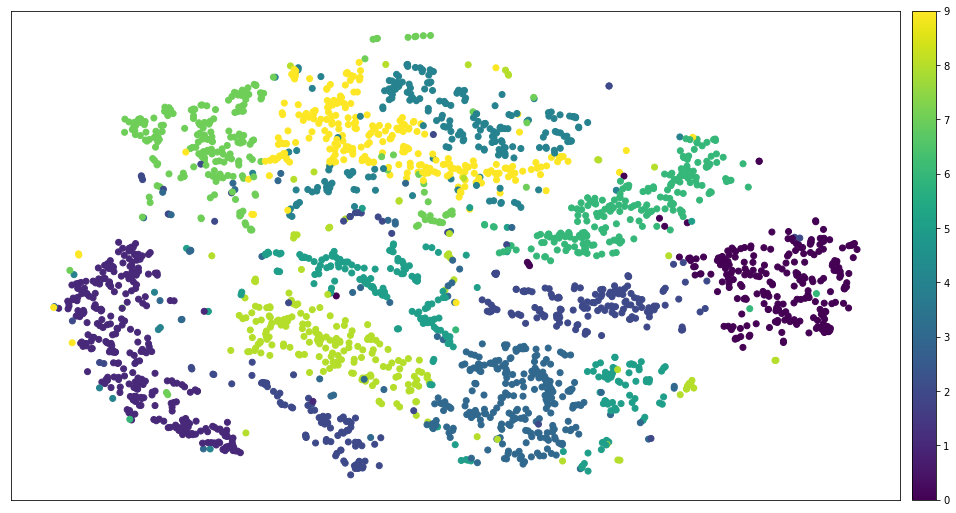

In [237]:
rcParams["figure.figsize"] = (17, 9)
scatter(embeddings[:, 0], embeddings[:, 1], c=target)
my_colorbar = colorbar(fraction=0.05, pad = 0.0125)
xticks([]); yticks([])

This is how the scatter plot looks like if we draw original images with alpha mask instead of dots.

([], <a list of 0 Text yticklabel objects>)

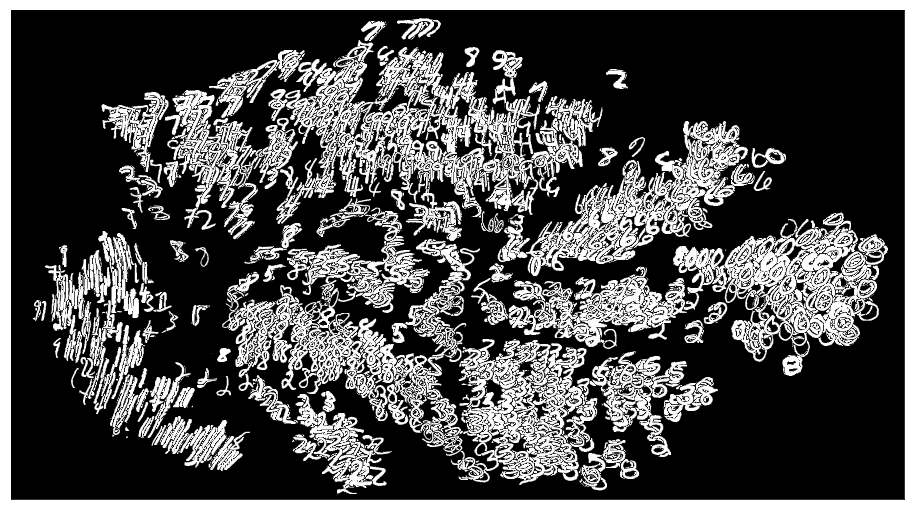

In [191]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

gca().set_facecolor("black")
rcParams["figure.figsize"] = (16, 9)
for pos, img in zip(embeddings, data):
    img = img.reshape(28, 28)
    img = stack((img, img, img, ones((28, 28), dtype=uint8) * 255), axis=-1)
    img[img[:, :, 0] == 0] = 0
    ab = AnnotationBbox(OffsetImage(img), 0.03 + pos * 0.94, xycoords="axes fraction", frameon=False)
    gca().add_artist(ab)
xticks([]); yticks([])

Let's define a regular grid with 2500 dots (54 by 54) on which we will project the samples after t-SNE.

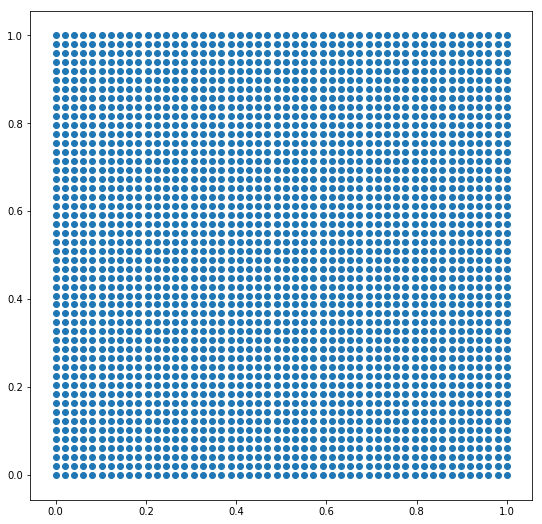

In [43]:
from scipy.spatial.distance import cdist
grid = dstack(meshgrid(linspace(0, 1, size), linspace(0, 1, size))).reshape(-1, 2)
rcParams["figure.figsize"] = (9, 9)
scatter(grid[:,0], grid[:,1])

We define the cost matrix - squared L2 distance from every sample to each of the grid nodes. Thus the matrix size is 2500 by 2500. We normalize it to 100000 - this makes Jonker-Volgenant algorithm more numerically stable. Finally, we run [lapjv](https://github.com/src-d/lapjv) and obtain the solution of our linear assignment problem.

In [42]:
from lapjv import lapjv

cost_matrix = cdist(grid, embeddings, "sqeuclidean").astype(float32)
cost_matrix = cost_matrix * (100000 / cost_matrix.max())
%time row_asses, col_asses, _ = lapjv(cost_matrix)

CPU times: user 5.3 s, sys: 0 ns, total: 5.3 s
Wall time: 5.31 s


This is the visualization of the found solution. Each arrow starts at the original sample and points to the corresponding optimal grid node.

([], <a list of 0 Text yticklabel objects>)

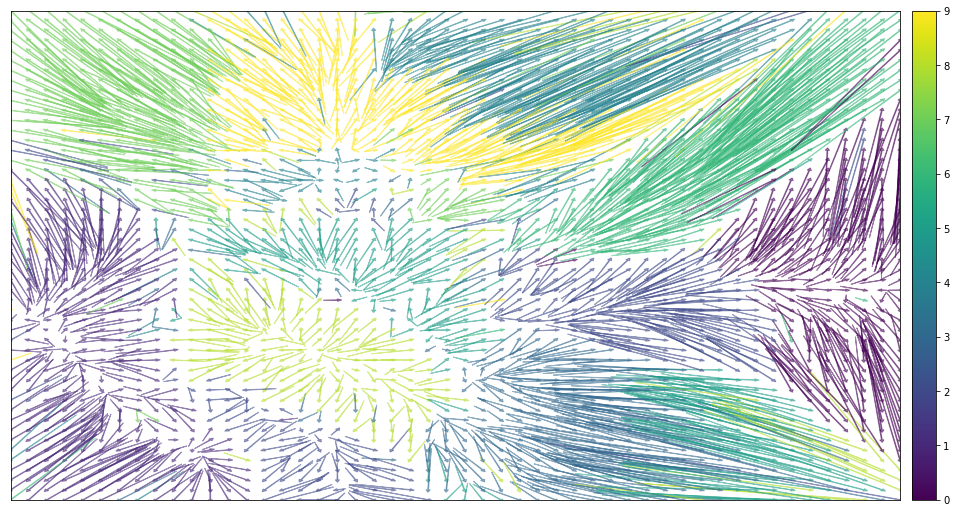

In [240]:
grid_jv = grid[col_asses]
pp_cmap = cm.get_cmap(rcParams["image.cmap"])
rcParams["figure.figsize"] = (17, 9)
for start, end, t in zip(embeddings, grid_jv, target):
    arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
          head_length=0.005, head_width=0.005, color=pp_cmap(t / 9), alpha=0.5)
colorbar(my_colorbar.mappable, fraction=0.05, pad = 0.0125)
xticks([]); yticks([])

Show the final MNIST 2D map. `grid_jv` contains the found optimal coordinates, we iterate it together with the corresponding images. Matplotlib seems to have a bug with AnnotationBbox - the actual OffsetImage size is double of that requested, so we need to scale each to (14, 14) so that they do not overlap. However, most MNIST images do not contain any useful information at the boundaries, so we "overcommit" and resize to (20, 20).

([], <a list of 0 Text yticklabel objects>)

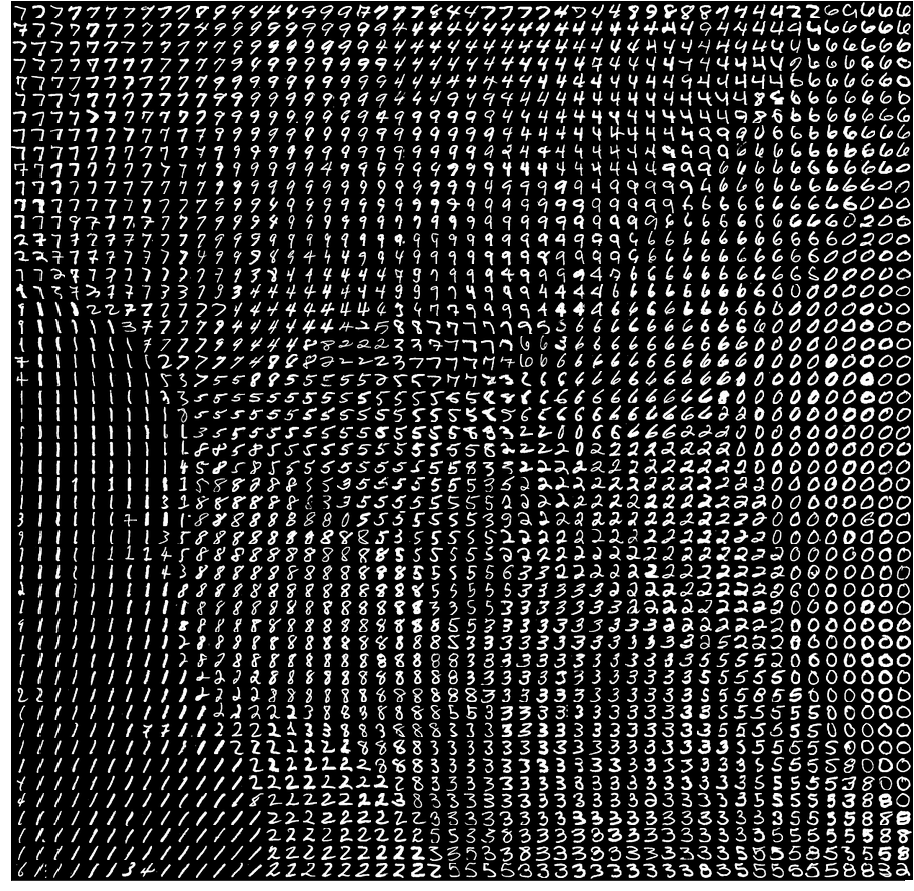

In [188]:
from PIL import Image

rcParams["figure.figsize"] = (16, 16)
gca().set_facecolor("black")
for pos, img in zip(grid_jv, data):
    img = Image.fromarray(255 - img.reshape(28, 28)).resize((20, 20), Image.ANTIALIAS)
    ab = AnnotationBbox(OffsetImage(img, cmap="Greys"),
                        pos * (size - 1) * 28, xycoords="data", frameon=False, box_alignment=(0, 0))
    gca().add_artist(ab)
xlim(0, (size - 1) * 28 + 16); ylim(0, (size - 1) * 28 + 16)
xticks([]); yticks([])